In [ ]:
# -----------------------------------
# Setup and Imports
# -----------------------------------
import pandas as pd
import numpy as np
from pathlib import Path
import torch
import random
import pytorch_lightning as pl
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import plotly.graph_objects as go
import plotly.subplots as sp
import plotly.io as pio
import plotly.express as px
from itertools import cycle
import holidays
from datetime import datetime, timedelta
import sys
import os
import shutil
import multiprocessing

# Import custom modules - make sure these paths are correct
sys.path.append(os.path.abspath('../'))
from src.utils import plotting_utils
from src.dl.dataloaders import TimeSeriesDataModule
from src.dl.multivariate_models import SingleStepRNNConfig, SingleStepRNNModel
from src.transforms.target_transformations import AutoStationaryTransformer
# Set default plotly template
pio.templates.default = "plotly_white"

# Set seeds for reproducibility
seed = 100
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Enable high precision matrix multiplication
torch.set_float32_matmul_precision('high')

In [ ]:
# -----------------------------------
# GPU Configuration
# -----------------------------------
# Check GPU Availability
gpu_available = torch.cuda.is_available()
print(f"GPU Available: {gpu_available}")

if gpu_available:
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

GPU Available: True
Using GPU: NVIDIA T600 Laptop GPU


In [ ]:
# -----------------------------------
# Data Loading and Preprocessing
# -----------------------------------
# Define Source Data Path
source_data = Path("../data/")

# Load Data
data = pd.read_csv(source_data / "processed" / "merged_nhs_covid_data.csv")
print("Initial Data Head:")
display(data.head())

# Display Unique Area Names
unique_areas = data['areaName'].unique()
print(f"Unique Areas: {unique_areas}")

# Aggregate Data to 'England' Region
data = data.groupby('date').agg({
    'covidOccupiedMVBeds': 'sum',
    'cumAdmissions': 'sum',
    'hospitalCases': 'sum',
    'newAdmissions': 'sum',
    'new_confirmed': 'sum',
    'new_deceased': 'sum',
    'cumulative_confirmed': 'sum',
    'cumulative_deceased': 'sum',
    'population': 'sum',
    'openstreetmap_id': 'first',
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()
data['areaName'] = 'England'

# Create Time Series Features
data['date'] = pd.to_datetime(data['date'])
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek

Initial Data Head:


,areaName,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,openstreetmap_id,latitude,longitude
0,East of England,2020-04-01,0.0,1400,833.0,167,334.0,75.0,2938.0,455.0,6235410,151336,52.24,0.41
1,East of England,2020-04-02,119.0,1584,841.0,184,372.0,71.0,3310.0,526.0,6235410,151336,52.24,0.41
2,East of England,2020-04-03,162.0,1776,914.0,192,350.0,85.0,3660.0,611.0,6235410,151336,52.24,0.41
3,East of England,2020-04-04,171.0,1939,988.0,163,268.0,70.0,3928.0,681.0,6235410,151336,52.24,0.41
4,East of England,2020-04-05,219.0,2159,1230.0,220,281.0,91.0,4209.0,772.0,6235410,151336,52.24,0.41


Unique Areas: ['East of England' 'London' 'Midlands' 'North East and Yorkshire'
 'North West' 'South East' 'South West']


In [ ]:
# -----------------------------------
# Vax Index Calculation
# -----------------------------------
def calculate_vax_index(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate the Vax index based on vaccination rates and efficacy across age groups.
    
    Args:
        df (pd.DataFrame): DataFrame containing 'date' and other relevant columns.
    
    Returns:
        pd.DataFrame: DataFrame with an additional 'Vax_index' column.
    """
    # Constants
    total_population = 60_000_000
    number_of_age_groups = 5
    vaccine_efficacy_first_dose = [0.89, 0.427, 0.76, 0.854, 0.75]
    vaccine_efficacy_second_dose = [0.92, 0.86, 0.81, 0.85, 0.80]
    age_group_probabilities_icu = [0.01, 0.02, 0.05, 0.1, 0.15]
    monthly_vaccination_rate_increase = 0.05
    vaccination_start_date = pd.Timestamp('2021-01-18')
    
    # Population per Age Group
    population_per_age_group = total_population / number_of_age_groups
    
    # Initialize Vax Index List
    vax_index_list = []
    
    # Monthly Vaccination Rate (Starting from 0)
    monthly_vaccination_rate = 0.0
    
    for index, row in df.iterrows():
        # Increment Monthly Vaccination Rate on the First Day of Each Month After Start Date
        if row['date'].day == 1 and row['date'] >= vaccination_start_date:
            monthly_vaccination_rate += monthly_vaccination_rate_increase
            # Ensure Vaccination Rate Does Not Exceed 1
            monthly_vaccination_rate = min(monthly_vaccination_rate, 1.0)
            print(f"Updated monthly vaccination rate to {monthly_vaccination_rate} on {row['date'].date()}")
        
        Si_sum = 0.0
        
        for i in range(number_of_age_groups):
            # Vaccinated Population for This Age Group
            vaccinated_population = monthly_vaccination_rate * population_per_age_group
            
            # Assume Half Received First Dose and Half Received Second Dose
            aij = vaccinated_population / 2  # First dose
            bij = vaccinated_population / 2  # Second dose
            cij = population_per_age_group - aij - bij  # Unvaccinated
            
            # Calculate S''i Based on Vaccine Efficacy
            S_double_prime_i = (vaccine_efficacy_second_dose[i] * bij +
                               vaccine_efficacy_first_dose[i] * aij)
            
            # Calculate Si (Effective Susceptible)
            Si = aij + bij + cij - S_double_prime_i  
            
            # Age-Specific Probability
            pi = age_group_probabilities_icu[i]
            
            # Normalize Si by Total Population in Age Group
            Si_normalized = Si / population_per_age_group
            
            # Weighted Sum
            Si_sum += pi * Si_normalized
        
        # Vax Index for the Day
        vax_index = Si_sum
        vax_index_list.append(vax_index)
    
    # Add Vax Index to the DataFrame
    df['Vax_index'] = vax_index_list
    print("Calculated Vax_index for all dates.")
    return df

# Calculate Vax Index
data = calculate_vax_index(data)
print("Data with Vax_index:")
display(data.head())

Updated monthly vaccination rate to 0.05 on 2021-02-01
Updated monthly vaccination rate to 0.1 on 2021-03-01
Updated monthly vaccination rate to 0.15000000000000002 on 2021-04-01
Updated monthly vaccination rate to 0.2 on 2021-05-01
Updated monthly vaccination rate to 0.25 on 2021-06-01
Updated monthly vaccination rate to 0.3 on 2021-07-01
Updated monthly vaccination rate to 0.35 on 2021-08-01
Updated monthly vaccination rate to 0.39999999999999997 on 2021-09-01
Updated monthly vaccination rate to 0.44999999999999996 on 2021-10-01
Updated monthly vaccination rate to 0.49999999999999994 on 2021-11-01
Updated monthly vaccination rate to 0.5499999999999999 on 2021-12-01
Updated monthly vaccination rate to 0.6 on 2022-01-01
Updated monthly vaccination rate to 0.65 on 2022-02-01
Updated monthly vaccination rate to 0.7000000000000001 on 2022-03-01
Updated monthly vaccination rate to 0.7500000000000001 on 2022-04-01
Updated monthly vaccination rate to 0.8000000000000002 on 2022-05-01
Updated 

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,openstreetmap_id,latitude,longitude,areaName,year,month,day,day_of_week,Vax_index
0,2020-04-01,0.0,23332,12059.0,3099,3989.0,694.0,35571.0,4730.0,56171302,151336,52.24,0.41,England,2020,4,1,2,0.33
1,2020-04-02,1494.0,26264,12135.0,2932,3895.0,725.0,39466.0,5455.0,56171302,151336,52.24,0.41,England,2020,4,2,3,0.33
2,2020-04-03,1788.0,28828,13635.0,2564,3878.0,737.0,43344.0,6192.0,56171302,151336,52.24,0.41,England,2020,4,3,4,0.33
3,2020-04-04,1950.0,31421,15469.0,2593,3260.0,828.0,46604.0,7020.0,56171302,151336,52.24,0.41,England,2020,4,4,5,0.33
4,2020-04-05,2097.0,34013,16657.0,2592,2994.0,823.0,49598.0,7843.0,56171302,151336,52.24,0.41,England,2020,4,5,6,0.33


In [ ]:
# -----------------------------------
# Data Visualization
# -----------------------------------
# Create Subplots with 5 Rows
fig = sp.make_subplots(
    rows=5, cols=1, 
    shared_xaxes=True, 
    subplot_titles=(
        'New Hospital Admissions', 
        'Current Hospital Cases',
        'Mechanical Ventilator Bed Usage',
        'New COVID-19 Cases',
        'Vax Index'
    )
)

# Plot New Hospital Admissions
fig.add_trace(
    go.Scatter(
        x=data['date'], 
        y=data['newAdmissions'], 
        line=dict(color='brown', width=2), 
        name='New Admissions'
    ), 
    row=1, col=1
)

# Plot Current Hospital Cases
fig.add_trace(
    go.Scatter(
        x=data['date'], 
        y=data['hospitalCases'], 
        line=dict(color='green', width=2), 
        name='Hospital Cases'
    ), 
    row=2, col=1
)

# Plot Mechanical Ventilator Beds Usage
fig.add_trace(
    go.Scatter(
        x=data['date'], 
        y=data['covidOccupiedMVBeds'], 
        line=dict(color='blue', width=2), 
        name='Ventilator Beds'
    ), 
    row=3, col=1
)

# Plot New COVID-19 Cases
fig.add_trace(
    go.Scatter(
        x=data['date'], 
        y=data['new_confirmed'], 
        line=dict(color='orange', width=2), 
        name='New Cases'
    ), 
    row=4, col=1
)

# Plot Vax Index
fig.add_trace(
    go.Scatter(
        x=data['date'], 
        y=data['Vax_index'], 
        line=dict(color='purple', width=2), 
        name='Vax Index'
    ), 
    row=5, col=1
)

# Update Layout
fig.update_layout(
    height=1200, 
    width=900, 
    title_text="COVID-19 Data Visualization for England",
    showlegend=True
)

fig.show()

c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\_plotly_utils\basevalidators.py:105: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
# -----------------------------------
# Utility Functions
# -----------------------------------
def format_plot(
    fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15
):
    """Format a Plotly figure with common styling options."""
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
    )
    return fig

def mase(actual, predicted, insample_actual):
    """Calculate the Mean Absolute Scaled Error (MASE)."""
    # Handle zero division case
    mae_insample = np.mean(np.abs(np.diff(insample_actual)))
    if mae_insample == 0:
        return np.nan
    
    mae_outsample = np.mean(np.abs(actual - predicted))
    return mae_outsample / mae_insample

def forecast_bias(actual, predicted):
    """Calculate the forecast bias."""
    return np.mean(predicted - actual)

def plot_forecast(pred_df, forecast_columns, forecast_display_names=None, save_path=None):
    """Plot the forecasted values against actual values."""
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)

    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = px.colors.qualitative.Set2
    act_color = colors[0]
    colors = cycle(colors[1:])

    fig = go.Figure()

    # Actual Data Plot
    fig.add_trace(
        go.Scatter(
            x=pred_df[mask].index,
            y=pred_df['covidOccupiedMVBeds'][mask],
            mode="lines",
            line=dict(color=act_color, width=2),
            name="Actual COVID-19 MVBeds Trends",
        )
    )

    # Predicted Data Plots
    for col, display_col in zip(forecast_columns, forecast_display_names):
        fig.add_trace(
            go.Scatter(
                x=pred_df[mask].index,
                y=pred_df.loc[mask, col],
                mode="lines+markers",
                marker=dict(size=4),
                line=dict(color=next(colors), width=2),
                name=display_col,
            )
        )

    return fig

def highlight_abs_min(s, props=""):
    """Highlight the absolute minimum in a series."""
    return np.where(s == np.nanmin(np.abs(s.values)), props, "")

def add_rolling_statistics(data, columns, windows=[7, 14]):
    """Add rolling statistics (mean, std) for specified columns and window sizes."""
    df = data.copy()
    
    for column in columns:
        for window in windows:
            df[f'{column}_rolling_mean_{window}'] = df[column].rolling(window=window).mean()
            df[f'{column}_rolling_std_{window}'] = df[column].rolling(window=window).std()
    
    return df

In [ ]:
# -----------------------------------
# Enhanced Feature Engineering
# -----------------------------------
def engineer_features(df):
    """
    Engineer comprehensive features for ventilator demand forecasting.
    
    Args:
        df (pandas.DataFrame): The input DataFrame containing COVID-19 data
        
    Returns:
        pandas.DataFrame: DataFrame with additional engineered features
    """
    # Create a copy to avoid modifying the original DataFrame
    data = df.copy()
    
    # Ensure date is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(data['date']):
        data['date'] = pd.to_datetime(data['date'])
    
    # Sort by date to ensure proper calculation of time-based features
    data = data.sort_values('date').reset_index(drop=True)
    
    #------------------
    # LOCKDOWN FEATURES
    #------------------
    # Define lockdown periods
    lockdown_dates = {
        'Lockdown 1': {'start': '2020-03-23', 'end': '2020-07-04'},
        'Lockdown 2': {'start': '2020-11-05', 'end': '2020-12-02'},
        'Lockdown 3': {'start': '2021-01-06', 'end': '2021-04-12'}
    }
    
    # Create lockdown indicators
    data['in_lockdown'] = 0
    data['days_since_lockdown_start'] = np.nan
    data['days_until_lockdown_end'] = np.nan
    
    # Create features for each lockdown period
    for lockdown_name, period in lockdown_dates.items():
        start_date = pd.to_datetime(period['start'])
        end_date = pd.to_datetime(period['end'])
        
        # Create binary indicator for this specific lockdown
        lockdown_col = f'in_{lockdown_name.lower().replace(" ", "_")}'
        data[lockdown_col] = ((data['date'] >= start_date) & (data['date'] <= end_date)).astype(int)
        
        # Update the general lockdown indicator
        data.loc[(data['date'] >= start_date) & (data['date'] <= end_date), 'in_lockdown'] = 1
        
        # Calculate days since lockdown start (for dates within and after the lockdown)
        mask_since = data['date'] >= start_date
        data.loc[mask_since, f'days_since_{lockdown_name.lower().replace(" ", "_")}_start'] = (
            (data.loc[mask_since, 'date'] - start_date).dt.days
        )
        
        # Calculate days until lockdown end (for dates within the lockdown)
        mask_until = (data['date'] >= start_date) & (data['date'] <= end_date)
        data.loc[mask_until, f'days_until_{lockdown_name.lower().replace(" ", "_")}_end'] = (
            (end_date - data.loc[mask_until, 'date']).dt.days
        )
        
        # Fill NaN values with -1 for dates before the lockdown period
        data[f'days_since_{lockdown_name.lower().replace(" ", "_")}_start'] = data[f'days_since_{lockdown_name.lower().replace(" ", "_")}_start'].fillna(-1)
        data[f'days_until_{lockdown_name.lower().replace(" ", "_")}_end'] = data[f'days_until_{lockdown_name.lower().replace(" ", "_")}_end'].fillna(-1)
    
    # Calculate days since/until any lockdown
    for i, row in data.iterrows():
        current_date = row['date']
        
        # Find the closest lockdown start date that's in the past
        past_starts = [(pd.to_datetime(period['start']), name) 
                       for name, period in lockdown_dates.items() 
                       if pd.to_datetime(period['start']) <= current_date]
        
        if past_starts:
            closest_past_start = max(past_starts, key=lambda x: x[0])
            data.at[i, 'days_since_lockdown_start'] = (current_date - closest_past_start[0]).days
        else:
            data.at[i, 'days_since_lockdown_start'] = -1
            
        # Find the closest lockdown end date that's in the future
        future_ends = [(pd.to_datetime(period['end']), name) 
                       for name, period in lockdown_dates.items() 
                       if pd.to_datetime(period['start']) <= current_date <= pd.to_datetime(period['end'])]
        
        if future_ends:
            closest_future_end = min(future_ends, key=lambda x: x[0])
            data.at[i, 'days_until_lockdown_end'] = (closest_future_end[0] - current_date).days
        else:
            data.at[i, 'days_until_lockdown_end'] = -1
    
    # Create a feature for time since last lockdown ended
    data['days_since_last_lockdown'] = -1
    for i, row in data.iterrows():
        current_date = row['date']
        
        # Find past lockdown end dates
        past_ends = [(pd.to_datetime(period['end']), name) 
                    for name, period in lockdown_dates.items() 
                    if pd.to_datetime(period['end']) < current_date]
        
        if past_ends and data.at[i, 'in_lockdown'] == 0:
            most_recent_end = max(past_ends, key=lambda x: x[0])
            data.at[i, 'days_since_last_lockdown'] = (current_date - most_recent_end[0]).days
    
    #-------------------------
    # RATE OF CHANGE FEATURES
    #-------------------------
    # 1. Rate of change (daily) for hospital cases
    data['hospitalCases_daily_change'] = data['hospitalCases'].diff()
    data['hospitalCases_pct_change'] = data['hospitalCases'].pct_change() * 100
    
    # 2. Rate of change (daily) for new admissions
    data['newAdmissions_daily_change'] = data['newAdmissions'].diff()
    data['newAdmissions_pct_change'] = data['newAdmissions'].pct_change() * 100
    
    # 3. Rate of change in ventilator usage
    data['vent_daily_change'] = data['covidOccupiedMVBeds'].diff()
    data['vent_pct_change'] = data['covidOccupiedMVBeds'].pct_change() * 100
    
    # 4. Rate of change in confirmed cases
    data['confirmed_daily_change'] = data['new_confirmed'].diff()
    data['confirmed_pct_change'] = data['new_confirmed'].pct_change() * 100
    
    #-------------------
    # MOMENTUM FEATURES
    #-------------------
    # Multi-day momentum features (change over 3 and 7 days)
    for col in ['hospitalCases', 'newAdmissions', 'covidOccupiedMVBeds', 'new_confirmed']:
        data[f'{col}_3day_momentum'] = data[col].diff(3)
        data[f'{col}_7day_momentum'] = data[col].diff(7)
    
    #---------------
    # RATIO FEATURES
    #---------------
    # 1. Percentage of hospital cases requiring ventilation
    data['pct_cases_ventilated'] = (data['covidOccupiedMVBeds'] / data['hospitalCases']) * 100
    
    # 2. Admission to hospital ratio
    data['admission_to_hospital_ratio'] = data['newAdmissions'] / data['hospitalCases']
    
    # 3. Ventilator to hospital ratio
    data['vent_to_hospital_ratio'] = data['covidOccupiedMVBeds'] / data['hospitalCases']
    
    # 4. Admission to ventilator ratio (proxy for severity)
    data['admission_to_vent_ratio'] = data['newAdmissions'] / data['covidOccupiedMVBeds']
    
    #----------------
    # CALENDAR FEATURES
    #----------------
    # 1. Weekend flag (0 for weekday, 1 for weekend)
    data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x in [5, 6] else 0)
    
    # 2. UK holiday flags
    uk_holidays = holidays.UK()
    data['is_holiday'] = data['date'].apply(lambda x: 1 if x in uk_holidays else 0)
    
    # 3. Day of month
    data['day_of_month'] = data['date'].dt.day
    
    # 4. Week of year
    data['week_of_year'] = data['date'].dt.isocalendar().week.astype(int)
    
    # 5. Quarter
    data['quarter'] = data['date'].dt.quarter
    
    #---------------------
    # PEAK-RELATED FEATURES
    #---------------------
    # Days since most recent peak in key metrics
    def days_since_peak(series):
        result = np.zeros(len(series))
        current_max = series.iloc[0]
        current_max_idx = 0
        
        for i in range(1, len(series)):
            if series.iloc[i] > current_max:
                current_max = series.iloc[i]
                current_max_idx = i
            
            result[i] = i - current_max_idx
        
        return result
    
    data['days_since_vent_peak'] = days_since_peak(data['covidOccupiedMVBeds'])
    data['days_since_hospital_peak'] = days_since_peak(data['hospitalCases'])
    data['days_since_admissions_peak'] = days_since_peak(data['newAdmissions'])
    
    # Days until next peak (forward-looking)
    def days_until_next_peak(series):
        n = len(series)
        result = np.zeros(n)
        
        # First pass to find all peaks
        peaks = []
        for i in range(1, n-1):
            if series.iloc[i] > series.iloc[i-1] and series.iloc[i] > series.iloc[i+1]:
                if len(peaks) == 0 or series.iloc[i] > series.iloc[peaks[-1]]:
                    peaks.append(i)
        
        # Second pass to assign days until next peak
        current_peak_idx = 0
        for i in range(n):
            if current_peak_idx < len(peaks):
                if i < peaks[current_peak_idx]:
                    result[i] = peaks[current_peak_idx] - i
                else:
                    current_peak_idx += 1
                    if current_peak_idx < len(peaks):
                        result[i] = peaks[current_peak_idx] - i
                    else:
                        result[i] = -1  # No more peaks ahead
            else:
                result[i] = -1  # No more peaks ahead
        
        return result
    
    # Apply to smoothed data to avoid minor fluctuations
    if 'covidOccupiedMVBeds_rolling_mean_7' in data.columns:
        data['days_until_next_vent_peak'] = days_until_next_peak(data['covidOccupiedMVBeds_rolling_mean_7'])
    
    #----------------------
    # ACCELERATION FEATURES
    #----------------------
    # Change in the rate of change (acceleration)
    data['hospitalCases_acceleration'] = data['hospitalCases_daily_change'].diff()
    data['vent_acceleration'] = data['vent_daily_change'].diff()
    data['admissions_acceleration'] = data['newAdmissions_daily_change'].diff()
    
    #-------------------
    # TREND RATIO FEATURES
    #-------------------
    # Moving average ratios (Short-term vs long-term trends)
    if all(col in data.columns for col in ['hospitalCases_rolling_mean_7', 'hospitalCases_rolling_mean_14']):
        data['hospital_trend_ratio'] = data['hospitalCases_rolling_mean_7'] / data['hospitalCases_rolling_mean_14']
    
    if all(col in data.columns for col in ['covidOccupiedMVBeds_rolling_mean_7', 'covidOccupiedMVBeds_rolling_mean_14']):
        data['vent_trend_ratio'] = data['covidOccupiedMVBeds_rolling_mean_7'] / data['covidOccupiedMVBeds_rolling_mean_14']
    
    if all(col in data.columns for col in ['newAdmissions_rolling_mean_7', 'newAdmissions_rolling_mean_14']):
        data['admissions_trend_ratio'] = data['newAdmissions_rolling_mean_7'] / data['newAdmissions_rolling_mean_14']
    
    #-------------
    # LAG FEATURES
    #-------------
    # Lag features for key metrics (t-1, t-7, t-14)
    for col in ['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions', 'new_confirmed']:
        data[f'{col}_lag_1'] = data[col].shift(1)
        data[f'{col}_lag_7'] = data[col].shift(7)
        data[f'{col}_lag_14'] = data[col].shift(14)
    
    #-----------------
    # SEASONAL FEATURES
    #-----------------
    # Season indicators (Winter, Spring, Summer, Fall)
    data['season'] = data['month'].apply(
        lambda x: 1 if x in [12, 1, 2] else 
                  2 if x in [3, 4, 5] else 
                  3 if x in [6, 7, 8] else 4
    )
    
    # Convert to one-hot encoding
    season_dummies = pd.get_dummies(data['season'], prefix='season')
    data = pd.concat([data, season_dummies], axis=1)
    
    #---------------
    # WAVE INDICATORS
    #---------------
    # COVID wave indicator using threshold approach
    def identify_waves(series, threshold_multiplier=1.5):
        # Use rolling mean to smooth the data
        smooth = series.rolling(window=14, min_periods=1).mean()
        # Calculate the overall mean
        overall_mean = smooth.mean()
        # Mark as wave when above threshold
        return (smooth > (overall_mean * threshold_multiplier)).astype(int)
    
    data['covid_wave'] = identify_waves(data['covidOccupiedMVBeds'])
    
    # Alternative wave indicator using rate of change
    if 'covidOccupiedMVBeds_rolling_mean_7' in data.columns:
        data['wave_momentum'] = (data['covidOccupiedMVBeds_rolling_mean_7'].diff(7) > 0).astype(int)
    
    #-------------------
    # LOCKDOWN INTERACTION
    #-------------------
    # Interaction features between lockdown and other metrics
    data['lockdown_hospital_interaction'] = data['in_lockdown'] * data['hospitalCases']
    data['lockdown_admission_interaction'] = data['in_lockdown'] * data['newAdmissions']
    data['lockdown_vent_interaction'] = data['in_lockdown'] * data['covidOccupiedMVBeds']
    
    # Lockdown effectiveness metrics (change in key metrics during lockdown periods)
    for col in ['hospitalCases', 'newAdmissions', 'covidOccupiedMVBeds']:
        data[f'{col}_lockdown_effect'] = data[col].diff(7) * data['in_lockdown']
    
    #-----------------
    # COMPOSITE FEATURES
    #-----------------
    # Combined features that might capture complex relationships
    data['composite_hospital_admission_ratio'] = (data['hospitalCases'] + data['newAdmissions']) / data['hospitalCases']
    data['delta_admission_to_ventilator'] = data['vent_daily_change'] - data['newAdmissions_daily_change']
    
    # Dynamic pressure indicator (how fast ventilator usage is growing relative to capacity)
    data['ventilator_pressure'] = data['vent_pct_change'] * data['vent_to_hospital_ratio']
    
    # Systems stress indicator (combining multiple factors)
    data['system_stress'] = (
        data['pct_cases_ventilated'] * 
        data['hospitalCases_pct_change'].clip(lower=0) * 
        (1 / (data['days_since_admissions_peak'] + 1))
    )
    
    # Fill NaN values created by diff and shift operations
    # For ratio columns, forward fill might be better
    ratio_cols = [col for col in data.columns if 'ratio' in col.lower()]
    data[ratio_cols] = data[ratio_cols].fillna(method='ffill')
    
    # For other columns with NaNs, use 0 (assuming start of the series)
    data = data.fillna(0)
    
    return data

In [ ]:
# -----------------------------------
# Data Processing Pipeline
# -----------------------------------
# Calculate rolling statistics for key metrics
print("Calculating rolling statistics...")
columns_to_compute = ['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions', 'new_confirmed', 'Vax_index']
data = add_rolling_statistics(data, columns_to_compute, windows=[7, 14])
print("Rolling statistics added.")

# Apply enhanced feature engineering
print("Applying enhanced feature engineering...")
enhanced_data = engineer_features(data)
print(f"Original data columns: {len(data.columns)}")
print(f"Enhanced data columns: {len(enhanced_data.columns)}")
print(f"New features added: {len(enhanced_data.columns) - len(data.columns)}")

# Data Splitting
# Find the minimum and maximum dates
min_date = enhanced_data['date'].min()
max_date = enhanced_data['date'].max()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

# Calculate the date ranges for train, val, and test

Calculating rolling statistics...
Rolling statistics added.
Applying enhanced feature engineering...
Original data columns: 39
Enhanced data columns: 116
New features added: 77
Minimum Date: 2020-04-01 00:00:00
Maximum Date: 2022-09-12 00:00:00


C:\Users\olarinoyem\AppData\Local\Temp\ipykernel_1560\3489460536.py:317: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [ ]:
enhanced_data

,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions,new_confirmed,new_deceased,cumulative_confirmed,cumulative_deceased,population,...,lockdown_hospital_interaction,lockdown_admission_interaction,lockdown_vent_interaction,hospitalCases_lockdown_effect,newAdmissions_lockdown_effect,covidOccupiedMVBeds_lockdown_effect,composite_hospital_admission_ratio,delta_admission_to_ventilator,ventilator_pressure,system_stress
0,2020-04-01,0.0,23332,12059.0,3099,3989.0,694.0,35571.0,4730.0,56171302,...,12059.0,3099,0.0,0.0,0.0,0.0,1.256986,0.0,0.000000,0.000000
1,2020-04-02,1494.0,26264,12135.0,2932,3895.0,725.0,39466.0,5455.0,56171302,...,12135.0,2932,1494.0,0.0,0.0,0.0,1.241615,1661.0,inf,3.879566
2,2020-04-03,1788.0,28828,13635.0,2564,3878.0,737.0,43344.0,6192.0,56171302,...,13635.0,2564,1788.0,0.0,0.0,0.0,1.188045,662.0,2.580531,54.030949
3,2020-04-04,1950.0,31421,15469.0,2593,3260.0,828.0,46604.0,7020.0,56171302,...,15469.0,2593,1950.0,0.0,0.0,0.0,1.167626,133.0,1.142141,42.389332
4,2020-04-05,2097.0,34013,16657.0,2592,2994.0,823.0,49598.0,7843.0,56171302,...,16657.0,2592,2097.0,0.0,0.0,0.0,1.155610,148.0,0.949040,19.336855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,2022-09-08,127.0,848252,4881.0,508,3192.0,36.0,19692527.0,164139.0,56171302,...,0.0,0,0.0,-0.0,-0.0,-0.0,1.104077,43.0,0.222387,0.001503
891,2022-09-09,122.0,848674,4797.0,422,2987.0,36.0,19695514.0,164175.0,56171302,...,0.0,0,0.0,-0.0,-0.0,-0.0,1.087972,81.0,-0.100128,0.000000
892,2022-09-10,129.0,849082,4650.0,408,2756.0,24.0,19698270.0,164199.0,56171302,...,0.0,0,0.0,-0.0,-0.0,-0.0,1.087742,21.0,0.159175,0.000000
893,2022-09-11,132.0,849581,4692.0,499,3768.0,27.0,19702038.0,164226.0,56171302,...,0.0,0,0.0,0.0,0.0,0.0,1.106351,-88.0,0.065426,0.004179


In [ ]:
# -----------------------------------
# Data Cleaning
# -----------------------------------
print("Performing data cleaning...")

# Check for missing values
missing_values = enhanced_data.isnull().sum()
print(f"Total missing values before cleaning: {missing_values.sum()}")
print("Columns with missing values:")
print(missing_values[missing_values > 0])

# Handle missing values in important columns
for col in enhanced_data.columns:
    # For ratio columns, use forward fill then backward fill
    if 'ratio' in col or 'momentum' in col or 'change' in col:
        enhanced_data[col] = enhanced_data[col].fillna(method='ffill')
        enhanced_data[col] = enhanced_data[col].fillna(method='bfill')
        enhanced_data[col] = enhanced_data[col].fillna(0)  # Any remaining NaNs become 0
    # For rolling statistics columns, use interpolation
    elif 'rolling' in col:
        enhanced_data[col] = enhanced_data[col].interpolate(method='linear')
        enhanced_data[col] = enhanced_data[col].fillna(method='bfill')
        enhanced_data[col] = enhanced_data[col].fillna(0)
    # For other numeric columns, use 0
    elif enhanced_data[col].dtype in [np.float64, np.float32, np.int64, np.int32]:
        enhanced_data[col] = enhanced_data[col].fillna(0)

# Check for infinite values and replace with column max/min
for col in enhanced_data.select_dtypes(include=[np.number]).columns:
    # Replace infinities with NaN first
    mask_pos_inf = np.isinf(enhanced_data[col]) & (enhanced_data[col] > 0)
    mask_neg_inf = np.isinf(enhanced_data[col]) & (enhanced_data[col] < 0)
    
    if mask_pos_inf.any():
        # Replace positive infinity with column maximum excluding infinity
        col_max = enhanced_data.loc[~np.isinf(enhanced_data[col]), col].max()
        enhanced_data.loc[mask_pos_inf, col] = col_max
        print(f"Replaced {mask_pos_inf.sum()} positive infinities in {col}")
    
    if mask_neg_inf.any():
        # Replace negative infinity with column minimum excluding infinity
        col_min = enhanced_data.loc[~np.isinf(enhanced_data[col]), col].min()
        enhanced_data.loc[mask_neg_inf, col] = col_min
        print(f"Replaced {mask_neg_inf.sum()} negative infinities in {col}")

# Handle division by zero issues in ratio columns
for col in enhanced_data.columns:
    if 'ratio' in col:
        # Check for very large values (potential division by small numbers)
        q99 = enhanced_data[col].quantile(0.99)
        if q99 > 1000:  # Arbitrary large value threshold
            print(f"Clamping extreme values in {col}")
            enhanced_data[col] = enhanced_data[col].clip(upper=q99)

# Check for outliers using IQR method for key columns
key_columns = ['covidOccupiedMVBeds', 'hospitalCases', 'newAdmissions', 'new_confirmed']
for col in key_columns:
    Q1 = enhanced_data[col].quantile(0.25)
    Q3 = enhanced_data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for outliers (typically 1.5 * IQR)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = ((enhanced_data[col] < lower_bound) | (enhanced_data[col] > upper_bound)).sum()
    print(f"Detected {outliers} outliers in {col}")
    
    # For this application we may want to keep outliers as they could represent 
    # genuine COVID-19 surges rather than data errors
    # If you decide to cap outliers, uncomment the line below:
    # enhanced_data[col] = enhanced_data[col].clip(lower=lower_bound, upper=upper_bound)

# Check for any remaining missing values
missing_after = enhanced_data.isnull().sum().sum()
print(f"Missing values after cleaning: {missing_after}")

print("Data cleaning completed.")

Performing data cleaning...
Total missing values before cleaning: 0
Columns with missing values:
Series([], dtype: int64)
Replaced 1 positive infinities in vent_pct_change
Replaced 1 positive infinities in admission_to_vent_ratio
Replaced 1 positive infinities in ventilator_pressure
Clamping extreme values in hospitalCases_acceleration
Detected 88 outliers in covidOccupiedMVBeds
Detected 31 outliers in hospitalCases
Detected 32 outliers in newAdmissions
Detected 58 outliers in new_confirmed
Missing values after cleaning: 0
Data cleaning completed.


C:\Users\olarinoyem\AppData\Local\Temp\ipykernel_1560\2978172299.py:22: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\olarinoyem\AppData\Local\Temp\ipykernel_1560\2978172299.py:16: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\olarinoyem\AppData\Local\Temp\ipykernel_1560\2978172299.py:17: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [ ]:


# Set the target variable
target = 'covidOccupiedMVBeds'

# Initialize the AutoStationaryTransformer with a seasonality period
# Adjust the seasonal_period based on your data's seasonality (for example, 7 for weekly seasonality)
seasonal_period = 7
auto_stationary = AutoStationaryTransformer(seasonal_period=seasonal_period)

# Fit and transform the target column to make it stationary
data_stat = auto_stationary.fit_transform(enhanced_data[[target]], freq="D")

# Replace the original target values with the transformed stationary values
enhanced_data[target] = data_stat.values

# Print the transformed data to check
enhanced_data.head()

AssertionError: timeseries inputs should have a datetime index

In [ ]:
# -----------------------------------
# Data Splitting and Preparation
# -----------------------------------
# Find the minimum and maximum dates
min_date = enhanced_data['date'].min()
max_date = enhanced_data['date'].max()

print("Minimum Date:", min_date)
print("Maximum Date:", max_date)

# Calculate the date ranges for train, val, and test sets
date_range = max_date - min_date
train_end = min_date + pd.Timedelta(days=int(date_range.days * 0.75))
val_end = train_end + pd.Timedelta(days=int(date_range.days * 0.10))

# Split the data into train, validation, and test sets based on the date ranges
train = enhanced_data[enhanced_data['date'] < train_end]
val = enhanced_data[(enhanced_data['date'] >= train_end) & (enhanced_data['date'] < val_end)]
test = enhanced_data[enhanced_data['date'] >= val_end]

# Calculate the percentage of dates in each dataset
total_samples = len(enhanced_data)
train_percentage = len(train) / total_samples * 100
val_percentage = len(val) / total_samples * 100
test_percentage = len(test) / total_samples * 100

print(f"# of Training samples: {len(train)} | # of Validation samples: {len(val)} | # of Test samples: {len(test)}")
print(f"Percentage of Dates in Train: {train_percentage:.2f}% | Percentage of Dates in Validation: {val_percentage:.2f}% | Percentage of Dates in Test: {test_percentage:.2f}%")
print(f"Max Date in Train: {train.date.max()} | Min Date in Validation: {val.date.min()} | Min Date in Test: {test.date.min()}")

# Drop the 'areaName' column as it's no longer needed
train = train.drop('areaName', axis=1)
val = val.drop('areaName', axis=1)
test = test.drop('areaName', axis=1)

# Set 'date' as Index
train.set_index("date", inplace=True)
val.set_index("date", inplace=True)
test.set_index("date", inplace=True)

# Concatenate the DataFrames
sample_df = pd.concat([train, val, test])

# Convert feature columns to float32
for col in sample_df.columns:
    if col != "type":
        sample_df[col] = sample_df[col].astype("float32")

print("Sample DataFrame created with all splits combined.")

Minimum Date: 2020-04-01 00:00:00
Maximum Date: 2022-09-12 00:00:00
# of Training samples: 670 | # of Validation samples: 89 | # of Test samples: 136
Percentage of Dates in Train: 74.86% | Percentage of Dates in Validation: 9.94% | Percentage of Dates in Test: 15.20%
Max Date in Train: 2022-01-30 00:00:00 | Min Date in Validation: 2022-01-31 00:00:00 | Min Date in Test: 2022-04-30 00:00:00
Sample DataFrame created with all splits combined.


In [ ]:
# -----------------------------------
# Feature Selection
# -----------------------------------
# Select the most relevant features for the model
base_features = [
    'covidOccupiedMVBeds_rolling_mean_7',
    'hospitalCases',
    'newAdmissions',
    'new_confirmed', 
    'Vax_index'
]

# Add lockdown features
lockdown_features = [
    'in_lockdown',
    'days_since_lockdown_start',
    'days_until_lockdown_end',
    'days_since_last_lockdown',
    'lockdown_hospital_interaction',
    'lockdown_admission_interaction',
    'lockdown_vent_interaction'
]

# Add ratio and momentum features
advanced_features = [
    'vent_to_hospital_ratio',
    'pct_cases_ventilated',
    'hospitalCases_3day_momentum',
    'vent_3day_momentum',
    'vent_lag_1',
    'vent_lag_7',
    'system_stress',
    'admission_to_vent_ratio'
]

# Add calendar features
calendar_features = [
    'year',
    'month',
    'day_of_week',
    'is_weekend',
    'is_holiday'
]

# Combine all features
selected_features = base_features + lockdown_features + advanced_features + calendar_features

# Filter to only include features that exist in the dataframe
selected_features = [f for f in selected_features if f in sample_df.columns]

# Select the features and the target variable
selected_df = sample_df[selected_features + ['covidOccupiedMVBeds']]

# Ensure the target column is the last column
cols = list(selected_df.columns)
if 'covidOccupiedMVBeds' in cols:
    cols.remove('covidOccupiedMVBeds')
    selected_df = selected_df[cols + ['covidOccupiedMVBeds']]

target = "covidOccupiedMVBeds"
pred_df = pd.concat([train[[target]], val[[target]]])

print("Feature selection completed. Selected DataFrame shape:", selected_df.shape)
print("Number of selected features:", len(selected_features))

Feature selection completed. Selected DataFrame shape: (895, 23)
Number of selected features: 22


In [ ]:
# -----------------------------------
# Model Training Setup
# -----------------------------------
# Determine optimal number of workers for data loading
num_workers = min(8, multiprocessing.cpu_count())
print(f"Setting num_workers to: {num_workers}")

# Create the TimeSeriesDataModule with the selected features
datamodule = TimeSeriesDataModule(
    data=selected_df,
    n_val=len(val),
    n_test=len(test),
    window=7, 
    horizon=1,  
    normalize="global",  
    batch_size=32,
    num_workers=num_workers,
)
datamodule.setup()

# Get the actual input size from the datamodule
actual_input_size = datamodule.train_dataloader().dataset[0][0].shape[1]
print(f"Actual input size from dataloader: {actual_input_size}")

# Configure the LSTM model with the correct input size
rnn_config = SingleStepRNNConfig(
    rnn_type="LSTM",  # Using LSTM instead of RNN for better handling of long-term dependencies
    input_size=actual_input_size,  # Use the actual input size from the dataloader
    hidden_size=64,
    num_layers=3,
    bidirectional=False,
    learning_rate=1e-3
)
model = SingleStepRNNModel(rnn_config)
model.float()

Setting num_workers to: 8
Actual input size from dataloader: 23


SingleStepRNNModel(
  (rnn): LSTM(23, 64, num_layers=3, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (loss): MSELoss()
)

In [ ]:
# -----------------------------------
# Model Training
# -----------------------------------
# Initialize Trainer with adjusted parameters
trainer = pl.Trainer(
    min_epochs=5,
    max_epochs=100,
    callbacks=[
        pl.callbacks.EarlyStopping(monitor="valid_loss", patience=10)
    ],
    log_every_n_steps=10,
    accelerator='gpu' if gpu_available else 'cpu',
    devices=1 if gpu_available else None,
    precision=16 if gpu_available else 32,  # Use mixed precision for faster training if GPU is available
)

# Train the model
print("Starting model training...")
trainer.fit(model, datamodule)
print("Model training completed.")

# Remove artifacts created during training
if os.path.exists("lightning_logs"):
    shutil.rmtree("lightning_logs")

c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\lightning_fabric\connector.py:565: UserWarning:

`precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Starting model training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type    | Params
---------------------------------
0 | rnn  | LSTM    | 89.3 K
1 | fc   | Linear  | 65    
2 | loss | MSELoss | 0     
---------------------------------
89.4 K    Trainable params
0         Non-trainable params
89.4 K    Total params
0.358     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.



c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.



Epoch 79: 100%|██████████| 21/21 [00:16<00:00,  1.30it/s, v_num=19, train_loss=1.7e-5, valid_loss=0.00198, valid_MAE=0.0409, train_MAE=0.00413]  
Model training completed.


In [ ]:
# -----------------------------------
# Model Evaluation
# -----------------------------------
# Initialize metric record
metric_record = []

# Get predictions for test set
print("Generating predictions...")
predictions = trainer.predict(model, datamodule.test_dataloader())
predictions = torch.cat(predictions).squeeze().detach().cpu().numpy()

# Denormalize predictions using datamodule's statistics
pred_denormalized = predictions * datamodule.train.std + datamodule.train.mean

# Get actual values from test set
actuals = test[target].values

# Calculate metrics
metrics = {
    "Algorithm": rnn_config.rnn_type,
    "MAE": mean_absolute_error(actuals, pred_denormalized),
    "MSE": mean_squared_error(actuals, pred_denormalized),
    "RMSE": np.sqrt(mean_squared_error(actuals, pred_denormalized)),
    "MAPE": mean_absolute_percentage_error(actuals, pred_denormalized),
    "MASE": mase(actuals, pred_denormalized, train[target].values),
    "Forecast Bias": forecast_bias(actuals, pred_denormalized)
}

# Format metrics for display
value_formats = ["{}", "{:.4f}", "{:.4f}", "{:.4f}", "{:.4f}", "{:.4f}", "{:.2f}"]
metrics_formatted = {key: fmt.format(value) for key, value, fmt in zip(metrics.keys(), metrics.values(), value_formats)}
metric_record.append(metrics_formatted)
print("Evaluation Metrics:")
for key, value in metrics_formatted.items():
    print(f"{key}: {value}")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Generating predictions...


c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 31.45it/s] 
Evaluation Metrics:
Algorithm: LSTM
MAE: 313.3051
MSE: 107846.0018
RMSE: 328.3992
MAPE: 1.6884
MASE: 11.7760
Forecast Bias: 313.31


In [ ]:
# -----------------------------------
# Visualization
# -----------------------------------
# Create DataFrame with predictions
pred_df = pd.DataFrame({"LSTM": pred_denormalized}, index=test.index)
pred_df = test[[target]].join(pred_df)

# Plot the forecast
fig = plot_forecast(
    pred_df, 
    forecast_columns=["LSTM"], 
    forecast_display_names=["LSTM with Enhanced Features"]
)

# Define Plot Title with Metrics
title = (f"{rnn_config.rnn_type}: MAE: {metrics['MAE']:.4f} | "
         f"MSE: {metrics['MSE']:.4f} | RMSE: {metrics['RMSE']:.4f} | "
         f"MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.2f}")

# Format and Display the Plot
fig = format_plot(fig, title=title)
fig.update_xaxes(type="date", range=[min_date + pd.Timedelta(days=365), max_date])
fig.show()

Performing residual analysis...


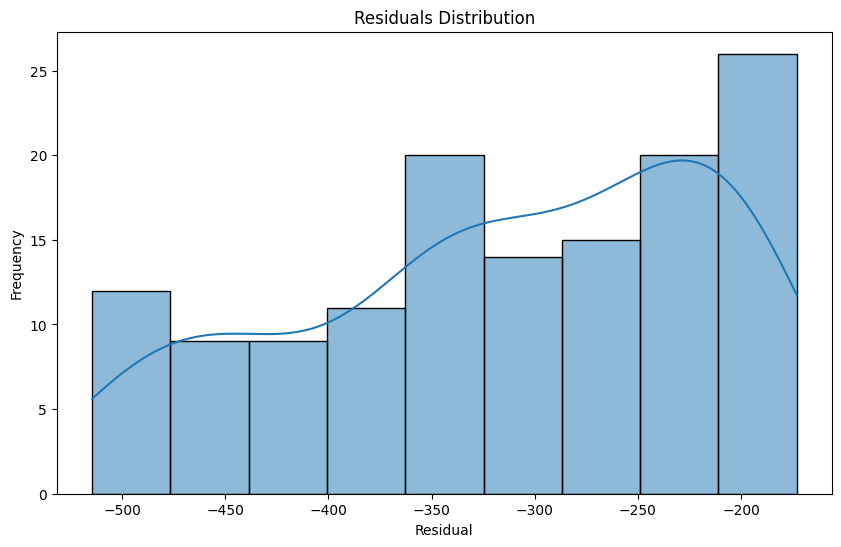

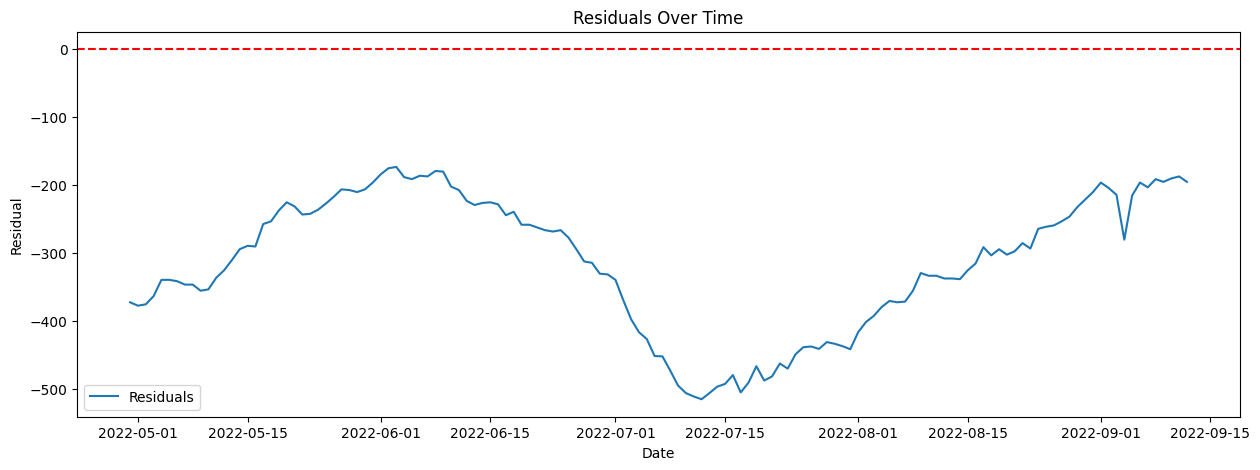

In [ ]:
# -----------------------------------
# Residual Analysis
# -----------------------------------
print("Performing residual analysis...")
residuals = actuals - pred_denormalized

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Plot residuals over time
plt.figure(figsize=(15, 5))
plt.plot(test.index, residuals, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals Over Time")
plt.xlabel("Date")
plt.ylabel("Residual")
plt.legend()
plt.show()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Analyzing feature importance...


c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 18.24it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing importance of covidOccupiedMVBeds_rolling_mean_7...


c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 11.14it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing importance of hospitalCases...


c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 14.12it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing importance of newAdmissions...


c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00,  9.43it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing importance of new_confirmed...


c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 142.85it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing importance of Vax_index...


c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 11.99it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing importance of in_lockdown...


c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 26.74it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing importance of days_since_lockdown_start...


c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 12.07it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing importance of vent_to_hospital_ratio...


c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 11.96it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing importance of pct_cases_ventilated...


c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00, 14.97it/s] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing importance of hospitalCases_3day_momentum...


c:\Users\olarinoyem\AppData\Local\miniconda3\envs\tf\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:436: UserWarning:

Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.



Predicting DataLoader 0: 100%|██████████| 5/5 [00:00<00:00,  9.45it/s] 


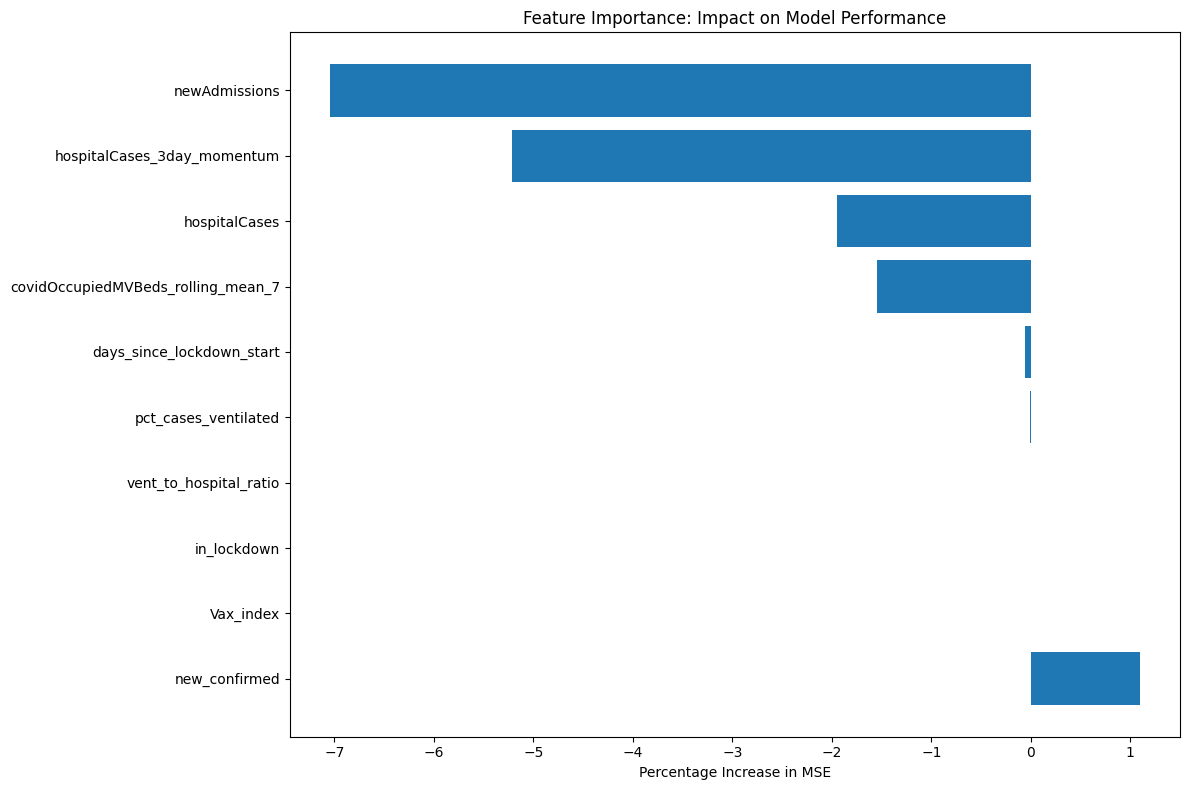

COVID-19 Forecasting Model Analysis Complete


In [ ]:
# -----------------------------------
# Feature Importance Analysis
# -----------------------------------
print("Analyzing feature importance...")

def calculate_feature_importance(model, datamodule, test_data, test_actuals, selected_features):
    """
    Calculate feature importance by perturbing each feature and measuring the impact on performance.
    
    Args:
        model (pl.LightningModule): Trained model
        datamodule (TimeSeriesDataModule): Data module
        test_data (pd.DataFrame): Test dataset
        test_actuals (np.array): Actual values
        selected_features (list): List of feature names
        
    Returns:
        dict: Dictionary of feature importance scores
    """
    # Get baseline predictions
    baseline_preds = trainer.predict(model, datamodule.test_dataloader())
    baseline_preds = torch.cat(baseline_preds).squeeze().detach().cpu().numpy()
    baseline_preds = baseline_preds * datamodule.train.std + datamodule.train.mean
    
    # Calculate baseline MSE
    baseline_mse = mean_squared_error(test_actuals, baseline_preds)
    
    feature_importance = {}
    
    # Iterate through each feature
    for feature in selected_features:
        print(f"Testing importance of {feature}...")
        # Create a copy of the datamodule with the feature perturbed
        perturbed_data = selected_df.copy()
        
        # Shuffle the feature values in the test portion
        test_indices = test_data.index
        orig_values = perturbed_data.loc[test_indices, feature].copy()
        perturbed_data.loc[test_indices, feature] = np.random.permutation(orig_values)
        
        # Create a new datamodule with the perturbed data
        perturbed_datamodule = TimeSeriesDataModule(
            data=perturbed_data,
            n_val=len(val),
            n_test=len(test),
            window=7,
            horizon=1,
            normalize="global",
            batch_size=32,
            num_workers=num_workers,
        )
        perturbed_datamodule.setup()
        
        # Get predictions with the perturbed feature
        perturbed_preds = trainer.predict(model, perturbed_datamodule.test_dataloader())
        perturbed_preds = torch.cat(perturbed_preds).squeeze().detach().cpu().numpy()
        perturbed_preds = perturbed_preds * perturbed_datamodule.train.std + perturbed_datamodule.train.mean
        
        # Calculate MSE with the perturbed feature
        perturbed_mse = mean_squared_error(test_actuals, perturbed_preds)
        
        # Calculate importance as the percentage increase in MSE
        importance = (perturbed_mse - baseline_mse) / baseline_mse * 100
        feature_importance[feature] = importance
        
    return feature_importance

# Choose a subset of features to analyze (computing all may be time-consuming)
importance_features = base_features + lockdown_features[:2] + advanced_features[:3]
feature_importance = calculate_feature_importance(
    model, datamodule, test, actuals, importance_features
)

# Sort features by importance
feature_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(list(feature_importance.keys()), list(feature_importance.values()))
plt.xlabel('Percentage Increase in MSE')
plt.title('Feature Importance: Impact on Model Performance')
plt.tight_layout()
plt.show()

print("COVID-19 Forecasting Model Analysis Complete")